In [2]:
from data_import import *
import matplotlib.pyplot as plt

# LOAD THE DATA AND SPLIT UP THINGS
X_tr, Y_tr, X_val, Y_val, classes, filepaths = read_csv_as_numpy() 

print(X_tr.shape)

(10212, 2500)


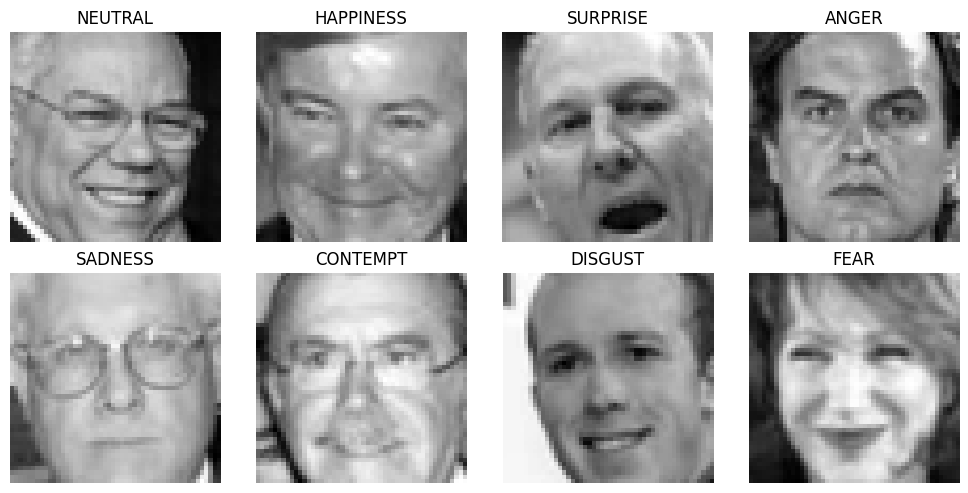

In [3]:
# Dictionary to store one sample per class
unique_samples = {}

# Collect one sample per class
for i in range(len(Y_tr)):
    label = classes[Y_tr[i]]  # Get the class name
    if label not in unique_samples:
        unique_samples[label] = (X_tr[i], filepaths[i])
        if len(unique_samples) == 8:  # Stop when we have 8 samples
            break

# Number of rows and columns
rows, cols = 2, 4

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Display each image
for ax, (label, (image, filepath)) in zip(axes, unique_samples.items()):
    ax.imshow(image.reshape(50, 50), cmap='gray')
    ax.set_title(label)
    ax.axis('off')  # Hide axes for clarity

# Hide any unused subplots
for ax in axes[len(unique_samples):]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


# TRAIN MODEL

# sklearn's mlp classifier requires flat data, so we flattened it

errors = []


# nn = MLPClassifier(hidden_layer_sizes=[128, 64],
#                     activation='relu',
#                     solver='sgd',
#                     batch_size = 256,
#                     learning_rate='constant',
#                     learning_rate_init=0.001)

nn = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=200)


nn.fit(X_tr, Y_tr)
error_curve_train = nn.loss_curve_

# plt.plot(error_curve_train)
# plt.xlim(0, 100)
# plt.show()

# y_pred = nn.predict(X_val)
# print(len(y_pred))
err = 1 - nn.score(X_val, Y_val)
print(f"Error: {err}")
# print(f"Predicted: {y_pred}   Actual: {Y_val}")

# print(classification_report(Y_val, y_pred))

# GRAPH

Error: 0.473168820994908


In [30]:
# RELOAD AND STRUCTURE DATA FOR CNN
import tensorflow as tf
X_tr, Y_tr, X_val, Y_val, classes, filepaths = read_csv_as_numpy()


X_tr = np.reshape(X_tr, (-1, 50, 50, 1))
# Y_tr = np.reshape(Y_tr, (-1, 50, 50, 1))
X_val = np.reshape(X_val, (-1, 50, 50, 1))
# Y_val = np.reshape(Y_val, (-1, 50, 50, 1))
X_tr = X_tr.astype('float32') / 255.0  # Scale to [0, 1]
X_val = X_val.astype('float32') / 255.0
# X_tr = X_tr[..., tf.newaxis]  # Shape: (num_samples, 50, 50, 1)
# X_val = X_val[..., tf.newaxis]


print(X_tr.shape)
print(X_val.shape)

from tensorflow.keras.utils import to_categorical
num_classes = len(set(Y_tr))
Y_tr = to_categorical(Y_tr, num_classes)
Y_val = to_categorical(Y_val, num_classes)

(10212, 50, 50, 1)
(2553, 50, 50, 1)


In [33]:
# CNN
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# Example data setup: replace with your own dataset
# Assuming `X_train`, `X_test`, `y_train`, `y_test` are ready

# Reshape data
# X_tr = np.reshape(X_tr, (-1, 50, 50, 1))
# X_val = np.reshape(X_val, (-1, 50, 50, 1))


# Normalize the image pixel values
# X_tr = X_tr.astype('float32') / 255.0  # Scale to [0, 1]
# X_val = X_val.astype('float32') / 255.0

# If images are grayscale, add a channel dimension


# If labels are integers (e.g., 0, 1, ..., num_classes-1), convert to one-hot

def create_model():
    input_shape=(50, 50, 1)
    num_classes=8

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model 

start = time.time()
# Build the CNN model
model = create_model()

# L2 Regularized model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1), kernel_regularizer=l2(0.01)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
#     Dense(8, activation='softmax')
# ])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Train the model
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# datagen.fit(X_tr)


# Train the model
start_time = time.time()
epochs = 10
batch_size = 32

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

training_time = time.time() - start_time

history = model.fit(
    X_tr, 
    Y_tr,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1 
)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

end = time.time()
print(f"Training took {end-start} seconds.")



Epoch 1/10


/Users/purugajare/Downloads/personal_projects/cs178_project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4666 - loss: 1.1971 - val_accuracy: 0.5292 - val_loss: 1.1054 - learning_rate: 0.0010
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5036 - loss: 0.9879 - val_accuracy: 0.5292 - val_loss: 1.0178 - learning_rate: 0.0010
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5168 - loss: 0.9637 - val_accuracy: 0.5292 - val_loss: 0.9768 - learning_rate: 0.0010
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5202 - loss: 0.9566 - val_accuracy: 0.5307 - val_loss: 0.9687 - learning_rate: 0.0010
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5284 - loss: 0.9461 - val_accuracy: 0.5288 - val_loss: 0.9447 - learning_rate: 0.0010
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5176 - loss: 0.9545 - val_accuracy: 0.5284 - val_loss: 0.9328 - learning_rate: 0.0010
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5205 - loss: 0.9615 -